Урок 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов.

Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

   1.  Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.
   2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.
   3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
    Выполнить задание 2 для трех моделей.
   
   4. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.
  5.  (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.



# Урок 6. Feature Engineering, Feature Selection, part II

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

Задание 3: использовать permutation importance, выполнить задание 1 и 2.

Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

Задание 5: использовать shap, выполнить задание 1 и 2.

Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics
from datetime import timedelta
from datetime import datetime

from sklearn.model_selection import train_test_split
# from sunbird.categorical_encoding import frequency_encoding
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import scipy.stats as st

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

from scipy.stats import ttest_rel

# from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
public_df = pd.read_csv('assignment_2_train_1.csv')

In [3]:
print("public_df.shape = {} rows, {} cols".format(*public_df.shape))

public_df.shape = 180000 rows, 412 cols


In [4]:
public_df.head()

TransactionID  isFraud  TransactionAmt ProductCD  card1  card2  card3  \
0        2987000        0            68.5         W  13926    0.0  150.0   
1        2987001        0            29.0         W   2755  404.0  150.0   
2        2987002        0            59.0         W   4663  490.0  150.0   
3        2987003        0            50.0         W  18132  567.0  150.0   
4        2987004        0            50.0         H   4497  514.0  150.0   

        card4  card5   card6  ...  card2_freq_enc  card3_freq_enc  \
0    discover  142.0  credit  ...        0.014506        0.879722   
1  mastercard  102.0  credit  ...        0.006756        0.879722   
2        visa  166.0   debit  ...        0.060522        0.879722   
3  mastercard  117.0   debit  ...        0.009867        0.879722   
4  mastercard  102.0  credit  ...        0.030389        0.879722   

   card4_freq_enc  card5_freq_enc card6_freq_enc addr1_freq_enc  \
0        0.013212        0.000272       0.317951       0.038156   
1        0.302797        0.054433       0.317951       0.071367   
2        0.657224        0.079844       0.681949       0.041217   
3        0.302797        0.037106       0.681949       0.015411   
4        0.302797        0.054433       0.317951       0.006967   

   addr2_freq_enc  TransactionAmt_d  TransactionAmt_c  TransactionAmt_log  
0        0.876289               0.5              68.0            4.226834  
1        0.876289               0.0              29.0            3.367296  
2        0.876289               0.0              59.0            4.077537  
3        0.876289               0.0              50.0            3.912023  
4        0.876289               0.0              50.0            3.912023  

[5 rows x 412 columns]

In [5]:
# Получим список катероиальных и числовых признаков.

categorical = []
numerical = []
for col, value in public_df.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

In [6]:
 # Выделим числовые и категриальные переменные. 
public_df[categorical]=public_df[categorical].astype('category')


In [7]:
evalute_model_results = {
    'model_name': [],
    'Train-score': [],
    'Val-score': [],
    'Test-score': []
}

In [8]:
def evalute_model(df, categorical, model_name=""):

 # Разделим выборки на тренировчную, тестовую и валидационную.
    x_train, x_test = train_test_split(df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1)
    y_train, y_test = train_test_split(df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

    x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
    y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)

    categorical_1= [] 
    for c in categorical:
        if c in x_train.columns:
            categorical_1.append(c)

    params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 50,
    "max_depth": 4,
    'random_state':1    
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(
        X=x_train,
        y=y_train,
        eval_set=[(x_val, y_val), (x_val, y_val)],
        early_stopping_rounds=50,
        categorical_feature=categorical_1,
      # num_boost_round=10000,
        eval_metric="auc",
        verbose=50
    )

    train_score =  roc_auc_score(y_train, model.predict(x_train))
    val_score = roc_auc_score(y_val, model.predict(x_val))
    test_score = roc_auc_score(y_test, model.predict(x_test))
   
    print(f"\r\n Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")
  
  # Заполним словарь c результатами обучения модели.
    evalute_model_results['model_name'].append(model_name)
    evalute_model_results['Train-score'].append(round(train_score, 3))
    evalute_model_results['Test-score'].append(round(test_score, 3))
    evalute_model_results['Val-score'].append(round(val_score, 3))
    
    return model

In [9]:
base_model= evalute_model(df=public_df, categorical=categorical, model_name='Base_line')

[50]	valid_0's auc: 0.875708	valid_1's auc: 0.875708
[100]	valid_0's auc: 0.881856	valid_1's auc: 0.881856
[150]	valid_0's auc: 0.884757	valid_1's auc: 0.884757
[200]	valid_0's auc: 0.886453	valid_1's auc: 0.886453
[250]	valid_0's auc: 0.887372	valid_1's auc: 0.887372
[300]	valid_0's auc: 0.888629	valid_1's auc: 0.888629
[350]	valid_0's auc: 0.890017	valid_1's auc: 0.890017
[400]	valid_0's auc: 0.891415	valid_1's auc: 0.891415
[450]	valid_0's auc: 0.892878	valid_1's auc: 0.892878
[500]	valid_0's auc: 0.893298	valid_1's auc: 0.893298
[550]	valid_0's auc: 0.893806	valid_1's auc: 0.893806

 Train-score: 0.758, Val-score: 0.67, Test-score: 0.662


## Задание 1.

Использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

In [10]:
# # Разделим выборки на тренировчную, тестовую и валидационную.
# x_train, x_test = train_test_split(public_df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1)
# y_train, y_test = train_test_split(public_df["isFraud"], train_size=0.60, shuffle=False, random_state=1) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

# x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1)
# y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1)


# params = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "auc",
#     "learning_rate": 0.1,
#     "n_estimators": 10000,
#     "reg_lambda": 50,
#     "max_depth": 4,
#     'random_state':1    
# }

# base_model = lgb.LGBMClassifier(**params)

# base_model.fit(
#     X=x_train,
#     y=y_train,
#     eval_set=[(x_val, y_val), (x_val, y_val)],
#     early_stopping_rounds=50,
#     categorical_feature=categorical,
#   # num_boost_round=10000,
#     eval_metric="auc",
#     verbose=20
# )

# train_score =  roc_auc_score(y_train, model.predict(x_train))
# val_score = roc_auc_score(y_val, model.predict(x_val))
# test_score = roc_auc_score(y_test, model.predict(x_test))

# print(f"\r\n Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")

importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

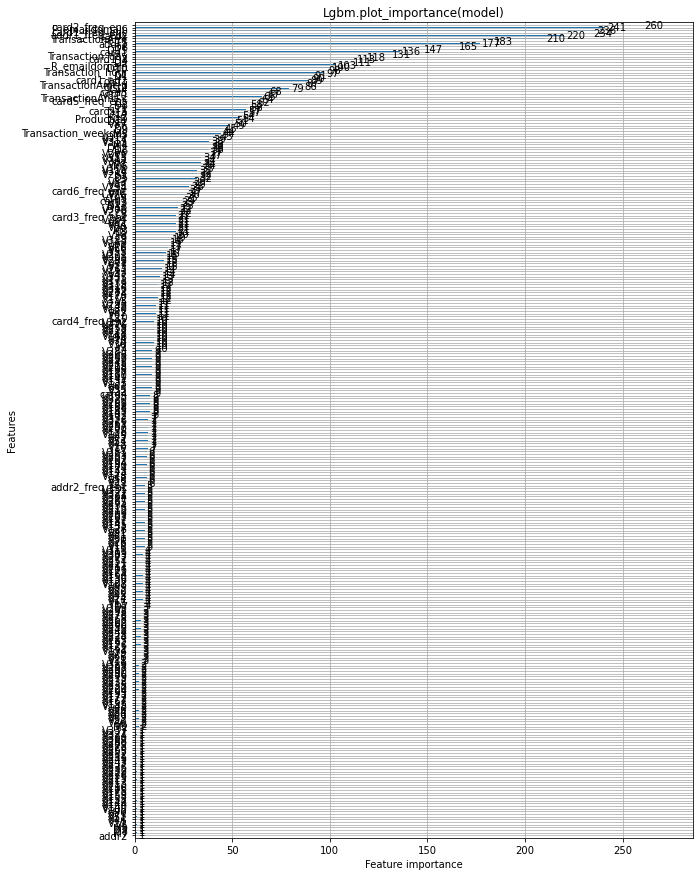

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
lgb.plot_importance(base_model, ax=ax, importance_type='auto')
plt.title("Lgbm.plot_importance(model)")
plt.show()

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
lgb.plot_importance(base_model, ax=ax, importance_type='split', max_num_features=50)
plt.title("Lgbm.plot_importance(model  importance='split')")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
lgb.plot_importance(base_model, ax=ax, importance_type='gain', max_num_features=50)
plt.title("Lgbm.plot_importance(model importance='gain')")
plt.show()

### Задание 2

удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [13]:
values= base_model.feature_importances_

In [14]:
# len(values)

In [15]:
# values = np.array(values)

In [16]:
importance = pd.DataFrame({
    "feature": public_df.drop(["TransactionID", "isFraud"], axis=1).columns,
    "importance": base_model.feature_importances_
})

In [17]:
importance_features= list(importance.loc[(importance['importance']>0), 'feature'].values)

In [18]:
len(importance_features)

307

In [19]:
importance_features.append('TransactionID')
importance_features.append('isFraud')

In [20]:
# categorical_1= [] 
# for c in categorical:
#     if c in importance_features:
#          categorical_1.append(c)

In [21]:
# importance = importance.sort_values(by="adversarial_importance", ascending=False)
# importance = importance.head(n=10)

In [22]:
evalute_model(df=public_df[importance_features], categorical=categorical, model_name='ligth_gbm_score')

[50]	valid_0's auc: 0.875708	valid_1's auc: 0.875708
[100]	valid_0's auc: 0.881856	valid_1's auc: 0.881856
[150]	valid_0's auc: 0.884572	valid_1's auc: 0.884572
[200]	valid_0's auc: 0.887244	valid_1's auc: 0.887244
[250]	valid_0's auc: 0.889253	valid_1's auc: 0.889253
[300]	valid_0's auc: 0.891308	valid_1's auc: 0.891308
[350]	valid_0's auc: 0.891914	valid_1's auc: 0.891914
[400]	valid_0's auc: 0.892681	valid_1's auc: 0.892681
[450]	valid_0's auc: 0.893914	valid_1's auc: 0.893914

 Train-score: 0.748, Val-score: 0.67, Test-score: 0.661


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [23]:
importance_features= list(importance.loc[(importance['importance']>5), 'feature'].values)
importance_features.append('TransactionID')
importance_features.append('isFraud')

In [24]:
evalute_model(df=public_df[importance_features], categorical=categorical, model_name='ligth_gbm_score')

[50]	valid_0's auc: 0.877096	valid_1's auc: 0.877096
[100]	valid_0's auc: 0.882273	valid_1's auc: 0.882273
[150]	valid_0's auc: 0.886724	valid_1's auc: 0.886724
[200]	valid_0's auc: 0.888232	valid_1's auc: 0.888232
[250]	valid_0's auc: 0.890141	valid_1's auc: 0.890141
[300]	valid_0's auc: 0.890935	valid_1's auc: 0.890935
[350]	valid_0's auc: 0.89241	valid_1's auc: 0.89241
[400]	valid_0's auc: 0.893683	valid_1's auc: 0.893683
[450]	valid_0's auc: 0.89383	valid_1's auc: 0.89383

 Train-score: 0.742, Val-score: 0.673, Test-score: 0.661


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [25]:
importance_features= list(importance.loc[(importance['importance']>10), 'feature'].values)
importance_features.append('TransactionID')
importance_features.append('isFraud')

In [26]:
evalute_model(df=public_df[importance_features], categorical=categorical, model_name='ligth_gbm_score')

[50]	valid_0's auc: 0.87473	valid_1's auc: 0.87473
[100]	valid_0's auc: 0.883116	valid_1's auc: 0.883116
[150]	valid_0's auc: 0.885329	valid_1's auc: 0.885329
[200]	valid_0's auc: 0.886878	valid_1's auc: 0.886878
[250]	valid_0's auc: 0.889128	valid_1's auc: 0.889128
[300]	valid_0's auc: 0.89023	valid_1's auc: 0.89023
[350]	valid_0's auc: 0.892596	valid_1's auc: 0.892596
[400]	valid_0's auc: 0.894175	valid_1's auc: 0.894175
[450]	valid_0's auc: 0.894047	valid_1's auc: 0.894047
[500]	valid_0's auc: 0.895091	valid_1's auc: 0.895091

 Train-score: 0.754, Val-score: 0.672, Test-score: 0.665


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

## Задание 3
 
 использовать permutation importance, выполнить задание 1 и 2.


In [27]:
# Разделим выборки на тренировчную, тестовую и валидационную.
x_train, x_test = train_test_split(public_df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1)
y_train, y_test = train_test_split(public_df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)

In [28]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(
   base_model, x_val, y_val, scoring="roc_auc", n_jobs=6, random_state=27
)

In [29]:
importance_scores = pd.DataFrame({
    "features": x_val.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)
decrease_scores

features  importance-mean  importance-std
0       V328         0.000000        0.000000
1       V319         0.000000        0.000000
2       V325         0.000000        0.000000
3       V190         0.000000        0.000000
4       V227         0.000000        0.000000
..       ...              ...             ...
218     V155        -0.000693        0.000037
219      V30        -0.000753        0.000177
220       C2        -0.001615        0.000563
221     V335        -0.003955        0.000274
222     V156        -0.008451        0.000261

[223 rows x 3 columns]

In [30]:
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

In [31]:
estimator = PermutationImportance(
    base_model, scoring="roc_auc", random_state=27
)
importance = estimator.fit(x_val.fillna(-9999), y_val)

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

In [ ]:
show_weights(importance, feature_names=x_val.columns.tolist(), top=x_val.shape[1])

In [34]:
# !pip install eli5

In [32]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.
estimator
    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [33]:
scores, importance = calculate_permutation_importance(
    estimator, roc_auc_score, x_val, y_val
)

  0%|          | 1/410 [00:01<12:54,  1.89s/it]


ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
importance

## Задание 4

использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.
